In [1]:
import cv2
import os
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import pandas as pd

In [ ]:
# Paths
RAW_DATA_PATH = Path("/home.local/stagiaire/Music/T/Data_task/train")
IMAGE_OUT = Path("/home.local/stagiaire/Music/T/processed_dataset/train/images")
MASK_OUT = Path("/home.local/stagiaire/Music/T/processed_dataset/train/masks")


# Create output directories
IMAGE_OUT.mkdir(parents=True, exist_ok=True)
MASK_OUT.mkdir(parents=True, exist_ok=True)


In [3]:
def extract_labeled_frames(video_path, mask_files, video_prefix):
    cap = cv2.VideoCapture(str(video_path))

    for mask_file in mask_files:
        frame_idx = int(mask_file.stem)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        success, frame = cap.read()

        if success:
            frame_name = f"{video_prefix}_{mask_file.name}"
            cv2.imwrite(str(IMAGE_OUT / frame_name), frame)
    
    cap.release()


In [ ]:
selected_videos = ['video_02', 'video_04', 'video_05','video_08','video_10','video_11_1','video_11_2','video_15_1','video_15_2','video_16','video_17_1','video_17_2','video_19']


for video_id in selected_videos:
    video_folder = RAW_DATA_PATH / video_id
    video_path = video_folder / "video_left.avi"
    mask_folder = video_folder / "segmentation"

    if not video_path.exists() or not mask_folder.exists():
        print(f"Skipping {video_id}: missing video or masks")
        continue

    print(f"Processing {video_id}")
    mask_files = sorted(mask_folder.glob("*.png"))

    extract_labeled_frames(video_path, mask_files, video_id)
    
    for mask_file in mask_files:
        new_name = f"{video_id}_{mask_file.name}"
        shutil.copy(mask_file, MASK_OUT / new_name)


Processing video_41
Processing video_42
Processing video_43
Processing video_44
Processing video_45
Processing video_46
Processing video_47
Processing video_48
Processing video_49
Processing video_50


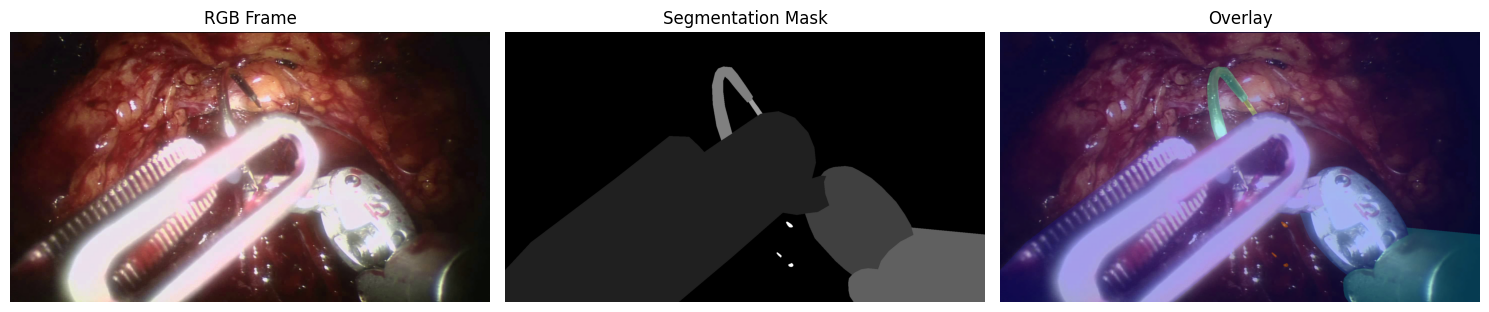

In [6]:
import numpy as np

sample_img_path = list(IMAGE_OUT.glob("*.png"))[0]
sample_mask_path = MASK_OUT / sample_img_path.name

img = cv2.imread(str(sample_img_path))
mask = cv2.imread(str(sample_mask_path), cv2.IMREAD_GRAYSCALE)


mask_colored = cv2.applyColorMap((mask * 25).astype(np.uint8), cv2.COLORMAP_JET)

# Overlay
overlay = cv2.addWeighted(img, 0.7, mask_colored, 0.3, 0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("RGB Frame"); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(mask, cmap='gray'); plt.title("Segmentation Mask"); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title("Overlay"); plt.axis('off')
plt.tight_layout(); plt.show()


#### See which tool types dominate or are underrepresented
#### Pixel Count per Class Across All Masks

Analyzing masks: 100%|██████████| 2758/2758 [01:01<00:00, 44.84it/s]


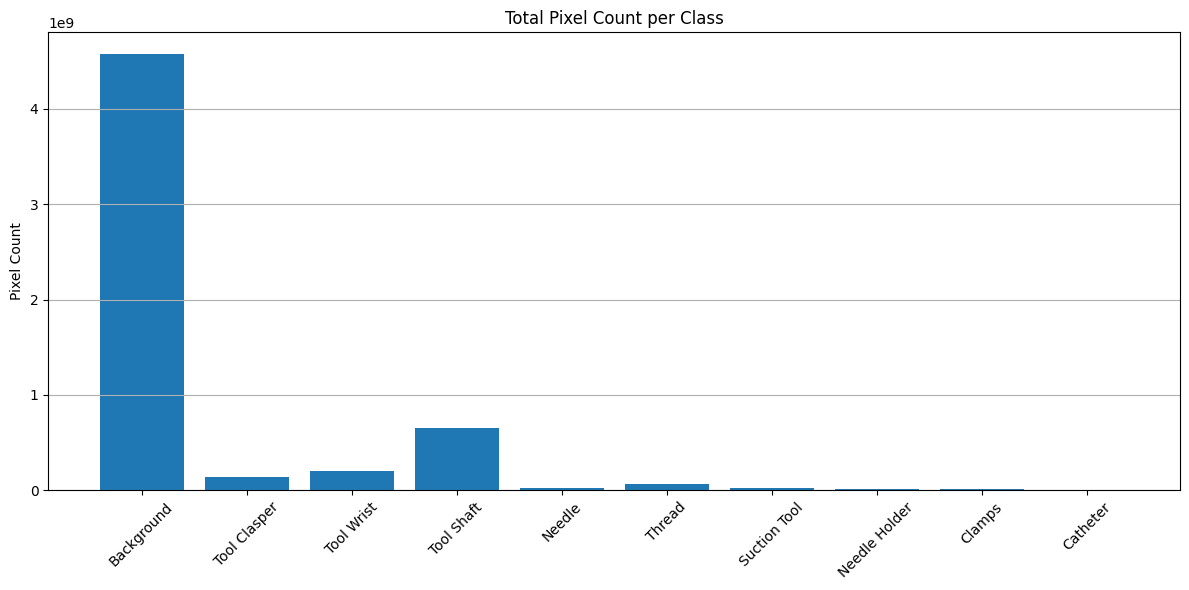

In [5]:
mask_paths = sorted(MASK_OUT.glob("*.png"))
class_pixel_counts = defaultdict(int)

for mask_path in tqdm(mask_paths, desc="Analyzing masks"):
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    unique, counts = np.unique(mask, return_counts=True)
    for cls, count in zip(unique, counts):
        class_pixel_counts[int(cls)] += count

# Sort and plot
classes = list(range(10))
counts = [class_pixel_counts[c] for c in classes]
labels = [
    "Background", "Tool Clasper", "Tool Wrist", "Tool Shaft",
    "Needle", "Thread", "Suction Tool", "Needle Holder", "Clamps", "Catheter"
]

plt.figure(figsize=(12, 6))
plt.bar(classes, counts)
plt.xticks(classes, labels, rotation=45)
plt.title("Total Pixel Count per Class")
plt.ylabel("Pixel Count")
plt.tight_layout()
plt.grid(axis='y')
plt.show()

#### Class Occurrence Across Images

Counting class presence in images: 100%|██████████| 2758/2758 [01:00<00:00, 45.30it/s]


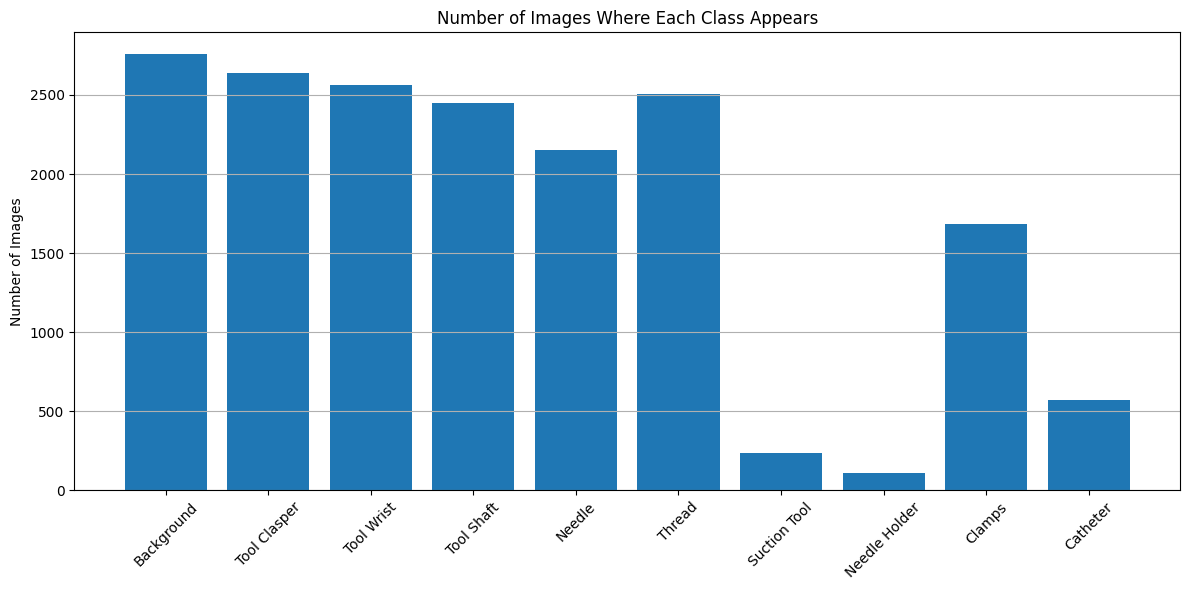

In [7]:
class_presence_counts = defaultdict(int)

for mask_path in tqdm(mask_paths, desc="Counting class presence in images"):
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    unique_classes = np.unique(mask)
    for cls in unique_classes:
        class_presence_counts[int(cls)] += 1

# Plotting
image_counts = [class_presence_counts[c] for c in classes]

plt.figure(figsize=(12, 6))
plt.bar(classes, image_counts)
plt.xticks(classes, labels, rotation=45)
plt.title("Number of Images Where Each Class Appears")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.grid(axis='y')
plt.show()

#### Class Imbalance Ratio

In [11]:
df = pd.DataFrame({
    "Class ID": classes,
    "Class": labels,
    "Pixel Count": counts,
    "Images Containing Class": image_counts
})

# Add imbalance ratios
df["Imbalance Ratio (Pixel)"] = df["Pixel Count"].max() / df["Pixel Count"]
df["Imbalance Ratio (Image)"] = df["Images Containing Class"].max() / df["Images Containing Class"]

# Show the table
display(df)

,Class ID,Class,Pixel Count,Images Containing Class,Imbalance Ratio (Pixel),Imbalance Ratio (Image)
0,0,Background,4569751215,2758,1.000000,1.000000
1,1,Tool Clasper,141228801,2638,32.357077,1.045489
2,2,Tool Wrist,208198857,2563,21.948974,1.076083
3,3,Tool Shaft,650392426,2448,7.026145,1.126634
4,4,Needle,29802744,2149,153.333237,1.283388
5,5,Thread,65737819,2507,69.514798,1.100120
6,6,Suction Tool,24424573,237,187.096463,11.637131
7,7,Needle Holder,14030861,112,325.692858,24.625000
8,8,Clamps,10948744,1683,417.376753,1.638740
9,9,Catheter,4472760,574,1021.684869,4.804878
